# 3.2. Bet365 Correction II: Unconventional use of Kelly Criterion for Bet Sizing

For Table 3: Corrected out-of-sample Bet365 strategy results.


In [4]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import econtools.metrics as mt
import numpy as np
from econtools import read, outreg, table_statrow, write_notes
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-deep')

In [5]:
# Test and training sets
original_df = pd.read_csv(r'https://raw.githubusercontent.com/Faxulous/notFeelingTheBuzz/main/DataFiles/ramirez_matches_cleaned.csv', index_col=0)
fitset = original_df[~(original_df['date'] > '2019-01-00')].copy()
testset = original_df[(original_df['date'] > '2019-01-00')].copy()

testset.reset_index(inplace=True)
print('Fit set rows: '+str(len(fitset)))
print('Test set rows: '+str(len(testset)))

Fit set rows: 15854
Test set rows: 5190


In [18]:
# All functions used for results

# Select regression by setting rankdist and wikibuzz True or False.
# For models PM, PM w/o RD (aka. WB), RD, MO.
def fit_regression(rankdist: bool = True, wikibuzz: bool = True):
    if wikibuzz and rankdist:
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'rankdist', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',
        addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1], results.beta[2]]
        #params= [constant        , inverse_avg    , rankdist       , wikibuzz       ]
    elif wikibuzz and not rankdist:
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        #params= [constant        , inverse_avg    , wikibuzz       ]
    elif rankdist and not wikibuzz:
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'rankdist'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        #params= [constant        , inverse_avg    , rankdist       ]
    elif not rankdist and not wikibuzz:
        results = mt.reg(fitset,'outcome',
        ['inverse_avg'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0]]
        #params= [constant        , inverse_avg    ]
    print(results)
    return params

# Returns model's estimated probability.
def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    if (rankdist is not None) & (wikibuzz is not None):
        y_hat = params[0] + params[-3]*inverse_odds + params[-2]*rankdist + params[-1]*wikibuzz
    if (rankdist is not None) & (wikibuzz is None):
        y_hat = params[0] + params[-2] * inverse_odds + params[-1] * rankdist
    if (wikibuzz is not None) & (rankdist is None):
        y_hat = params[0] + params[-2]*inverse_odds + params[-1]*wikibuzz
    if (rankdist is None) and (wikibuzz is None):
        y_hat = params[0] + params[1]*inverse_odds
    print(params[0])
    return y_hat

def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    k = max(y_hat - ((1 - y_hat)/(odds - 1)), 0)
    return k

# Calculates Profit/Loss.
def profit_loss(kelly, odds_implied_prob, outcome):
    odds = 1 / odds_implied_prob
    if outcome == 1:
        PnL = kelly*odds - kelly
    if outcome == 0:
        PnL = -kelly
    return PnL

# Estimates probability according to model selection, creates new columns, and prints results
def show_results(testset, params, odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"

    # Estimate Probability.
    if rankdist and wikibuzz:
        testset['model_est_prob'] = [estimate_probability(params, row[0], row[1], row[2]) for row in zip(testset['inverse_avg'],
                                                                                                         testset['rankdist'],
                                                                                                         testset['wikibuzz'])]
    elif wikibuzz and not rankdist:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], wikibuzz=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['wikibuzz'])]
    elif rankdist and not wikibuzz:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], rankdist=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['rankdist'])]
    elif not rankdist and not wikibuzz:
        testset['model_est_prob'] = [simple_probability(params, inverse_odds=x) for x in testset['inverse_avg']]
    # Determine kelly bet size.
    testset['kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)],
                                                                               testset['model_est_prob'])]
    # Calculate return for the bet.
    testset['PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],testset['inverse_{}'.format(odds)],
                                                                         testset['outcome'])]

    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute amount bet: '+str(testset['kelly_betsize'].sum()))
    print('Absolute return: '+str(testset['PnL'].sum()))
    print('ROI (%): '+str((((testset['PnL'].sum() + testset['kelly_betsize'].sum())/testset['kelly_betsize'].sum())-1)*100))

# PnL plot
def plot_results():
    testset['Cum_PnL'] = testset['PnL'].cumsum() * 100
    plt.rcParams.update({'font.size': 8}) # 16
    fig, ax = plt.subplots(1, 1, figsize=(3, 3)) # 6, 6
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=1.25) # 2.5

    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()

    ax.set_ylim(-100, 360)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)

    plt.show()


# Estimates probability according to model selection, creates new columns, and prints results - WITH CONVENTIONAL KELLY
def correct_kelly_results(odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"

    params = fit_regression(rankdist=rankdist,wikibuzz=wikibuzz)
    show_results(testset, params, odds, rankdist=rankdist, wikibuzz=wikibuzz)

    testset['bankroll_after'] = testset['PnL'] + 1
    testset['bankroll_after'] = testset['bankroll_after'].cumprod()
    testset['bankroll_before'] = testset.bankroll_after.shift(1)
    testset['betsize_of_inital_bankroll'] = testset['kelly_betsize'] * testset['bankroll_before']
    testset['pnl_of_initial_bankroll'] = testset['PnL'] * testset['bankroll_before']
    print("---------------")
    print("*Correct Kelly*")
    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute amount bet: ' + str(testset['betsize_of_inital_bankroll'].sum()))
    print('Absolute return: ' + str(testset['pnl_of_initial_bankroll'].sum()))
    print('ROI (%): ' + str((((testset['pnl_of_initial_bankroll'].sum() + testset['betsize_of_inital_bankroll'].sum()) / testset[
    'betsize_of_inital_bankroll'].sum()) - 1)*100))

# PnL plot - WITH CONVENTIONAL KELLY
def correct_kelly_plot_results():
    testset["Cum_PnL"] = (testset["bankroll_after"] -1) * 100
    plt.rcParams.update({'font.size': 8}) # 16
    fig, ax = plt.subplots(1, 1, figsize=(3, 3)) # 6, 6
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=1.25) # 2.5
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)

    plt.show()

In [26]:
# Remove Hercog bet
# (see correction1 for Table 3 CC results)
testset.drop(index=1135, inplace=True)

KeyError: '[1135] not found in axis'

Dependent variable:	outcome
N:			15854
R-squared:		0.1589
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.025 0.028 36.945 0.000  0.971   1.080
rankdist     0.055 0.031  1.787 0.074 -0.005   0.115
wikibuzz     0.009 0.004  2.117 0.034  0.001   0.017
_cons       -0.041 0.015 -2.831 0.005 -0.070  -0.013

Bets considered (2 * Matches): 5155
Number of bets placed: 311
Mean overround (%): 6.466222358689877
Absolute amount bet: 6.765670747988662
Absolute return: -0.4979083035833616
ROI (%): -7.359333939378931
---------------
*Correct Kelly*
Bets considered (2 * Matches): 5155
Number of bets placed: 311
Mean overround (%): 6.466222358689877
Absolute amount bet: 5.875868090896786
Absolute return: -0.49841303212080945
ROI (%): -8.482372721963893


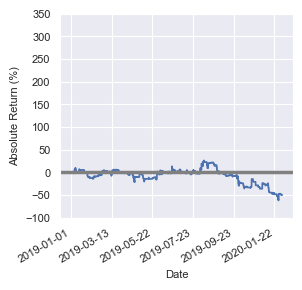

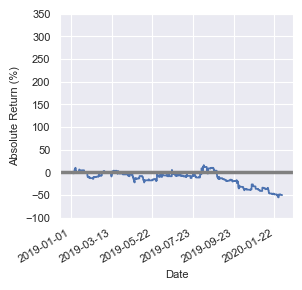

In [27]:
# Table 3 PM CC/H and CC/HK results
correct_kelly_results("b365", rankdist=True, wikibuzz=True)
plot_results()
correct_kelly_plot_results()

Dependent variable:	outcome
N:			15854
R-squared:		0.1586
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.005 0.025 39.826 0.000  0.956   1.055
wikibuzz     0.010 0.004  2.265 0.024  0.001   0.018
_cons       -0.031 0.013 -2.323 0.020 -0.057  -0.005

Bets considered (2 * Matches): 5155
Number of bets placed: 275
Mean overround (%): 6.466222358689877
Absolute amount bet: 4.6039147201459425
Absolute return: -0.2903874179608172
ROI (%): -6.307402191663791
---------------
*Correct Kelly*
Bets considered (2 * Matches): 5155
Number of bets placed: 275
Mean overround (%): 6.466222358689877
Absolute amount bet: 3.9427315831832646
Absolute return: -0.32302682773732105
ROI (%): -8.1929703030029


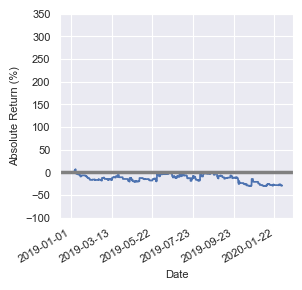

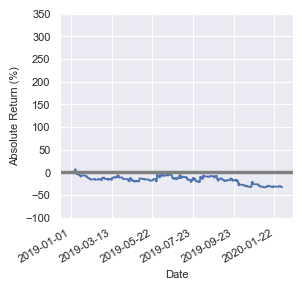

In [28]:
# Table 3 PM CC/H and CC/HK results
correct_kelly_results("b365", rankdist=False, wikibuzz=True)
plot_results()
correct_kelly_plot_results()